# Study the MSE

So the MSE that Majid is refering to is the MSE obtained by regressing the absorbances against the concentrations at the wavelength of greatest variance in absorbances.

Majid's hypothesis is that: "by incorporating more data than just the absorbances at the single wavelength of greatest variance, we can significantly reduce the MSE.

To test this I will:
1. calculate what the MSE is at the wavelength of highest variance
2. Remove wavelengths of high correlation between each other
   1. 
3. Fit a lasso model using the data from all wavelengths of the data
   1. vary the lasso selection threshold ($\alpha$) to identify how the number of data points affects the MSE


# load imports and data

In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
# use lasso from sklearn
from sklearn.linear_model import Lasso
from tqdm import tqdm
import seaborn as sns
from itertools import combinations
import math
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

RANDOM_SEED = 19890417

In [2]:
# load the data from the previous part
data = pd.read_csv('../p01_extract_data_from_fig/colorimetry_data_PS_extracted.csv')
data.rename(columns={'Wavelength (nm)':"wavelength",'Smoothed Absorbance':"sm_absorbance"}, inplace=True)

# Determine Wavelength of highest Variance and fit model

In [3]:
wv_highest_variance = None
for wv in np.unique(data['wavelength']):
    df = data[data['wavelength'] == wv]
    if wv_highest_variance is None or df['sm_absorbance'].var() > wv_highest_variance['sm_absorbance'].var():
        wv_highest_variance = df
print(wv_highest_variance['wavelength'].values[0],wv_highest_variance['sm_absorbance'].var())

652.1784232365146 0.003993509394281987


In [4]:
wv_highest_variance

,wavelength,Absorbance,Color,Concentration,sm_absorbance,webcolor
195,652.178423,0.284016,black,0,0.282795,#000000
578,652.178423,0.275820,red,5,0.275289,#FF0001
961,652.178423,0.240574,blue,10,0.239817,#0D0CF9
1344,652.178423,0.224180,green,20,0.224142,#017F03
1727,652.178423,0.191393,pink,30,0.190823,#FF02FF
2110,652.178423,0.159426,magenta,40,0.159388,#8604B4
2493,652.178423,0.144672,navy,50,0.144475,#0203A6
2876,652.178423,0.128279,orange,60,0.128354,#FF870C
3259,652.178423,0.123361,purple,80,0.122924,#9011EE
3642,652.178423,0.118443,salmon,100,0.118463,#FF0381


In [5]:
# fit an OLS model with absorbance as the dependent variable and the concentration as the independent variable
# use R model syntax
model = sm.OLS.from_formula('Concentration ~ sm_absorbance', data=wv_highest_variance)
results = model.fit()
# print the MSE of the model
print(results.mse_resid)
results.summary()

168.79064786196122


c:\Users\craut\.virtualenvs\colorimetry_ML-6CtRR2jE\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Concentration   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     50.79
Date:                Sat, 05 Apr 2025   Prob (F-statistic):           9.94e-05
Time:                        06:18:55   Log-Likelihood:                -38.717
No. Observations:                  10   AIC:                             81.43
Df Residuals:                       8   BIC:                             82.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       131.6291     13.565      9.704      0.000     100.348     162.910
sm_absorbance  -488.3677     68.529     -7.126      0.000    -646.396    -330.339
==============================================================================
Omnibus:                        3.152   Durbin-Watson:                   0.635
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                1.323
Skew:                           0.891   Prob(JB):                        0.516
Kurtosis:                       2.997   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Remove wavelengths of high correlation

In [6]:
# first transform the data to wide format
wide_data = data.pivot(index='Concentration', columns='wavelength', values='sm_absorbance')
rename_dict = {c:f"abs_wv_{round(c,3)}" for c in wide_data.columns}
wide_data = wide_data.rename(columns=rename_dict).reset_index()
X = wide_data.drop(columns='Concentration')
y = wide_data['Concentration']

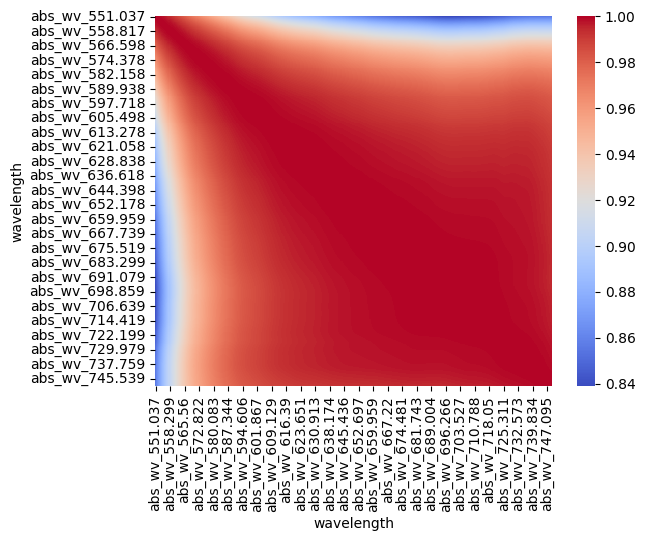

In [7]:
# first study the correlation between the variables by using a correlation heatmap
ax = sns.heatmap(X.corr(), cmap='coolwarm')

So the protocol to remove the correlated features is a typical protocol:
1. rank the features by order of increasing MSE in a sv model against concentration
   1. we want to process the most informative wavelengths 1st
   2. An alternative would be to sort the wavelengths by variance (prefer to keep the wavelength with highest variance 1st)
   3. Average absorbtions every 10 nms
2. iterate through the features keeping each feature if its correlation threshold between all the previously kept features is less than a threshold
   1. use 0.95 as the threshold (taken from "mid" of heatmap)

## attempt 1: Sort Wavelengths by importance to concentration

In [8]:
# first build a correlation matrix for lookup
corr_matrix = X.corr().abs()

# now fit the sv linear regression models for all the features and map each feature to the MSE
mse_map = {}
for col in tqdm(X.columns):
    df = pd.DataFrame(wide_data[[col, 'Concentration']])
    df.rename(columns={col:"wv"}, inplace=True)
    model = sm.OLS.from_formula(f'Concentration ~ wv', data=df)
    results = model.fit()
    mse_map[col] = results.mse_resid
# sort the features by the MSE
sorted_features = sorted(mse_map, key=mse_map.get)
thresh = 0.999 # 1 - 1e-4
kept_features = []
for test_feat in sorted_features:
    for feat in kept_features:
        if corr_matrix.loc[test_feat, feat] > thresh:
            break
    else:
        kept_features.append(test_feat)
print(kept_features)

100%|██████████| 383/383 [00:03<00:00, 122.01it/s]

['abs_wv_594.087', 'abs_wv_606.535', 'abs_wv_585.788', 'abs_wv_621.577', 'abs_wv_578.527', 'abs_wv_571.784', 'abs_wv_645.436', 'abs_wv_738.797', 'abs_wv_566.598', 'abs_wv_679.668', 'abs_wv_562.448', 'abs_wv_558.299', 'abs_wv_554.668', 'abs_wv_551.556']


In [9]:
# # this is the wavelength of highest variance
# kept_features.append("abs_wv_652.178")

In [10]:
print(len(kept_features), "abs_wv_652.178" in kept_features)

14 False


In [11]:
X_filt = X[kept_features]
print(X_filt.shape)

(10, 14)


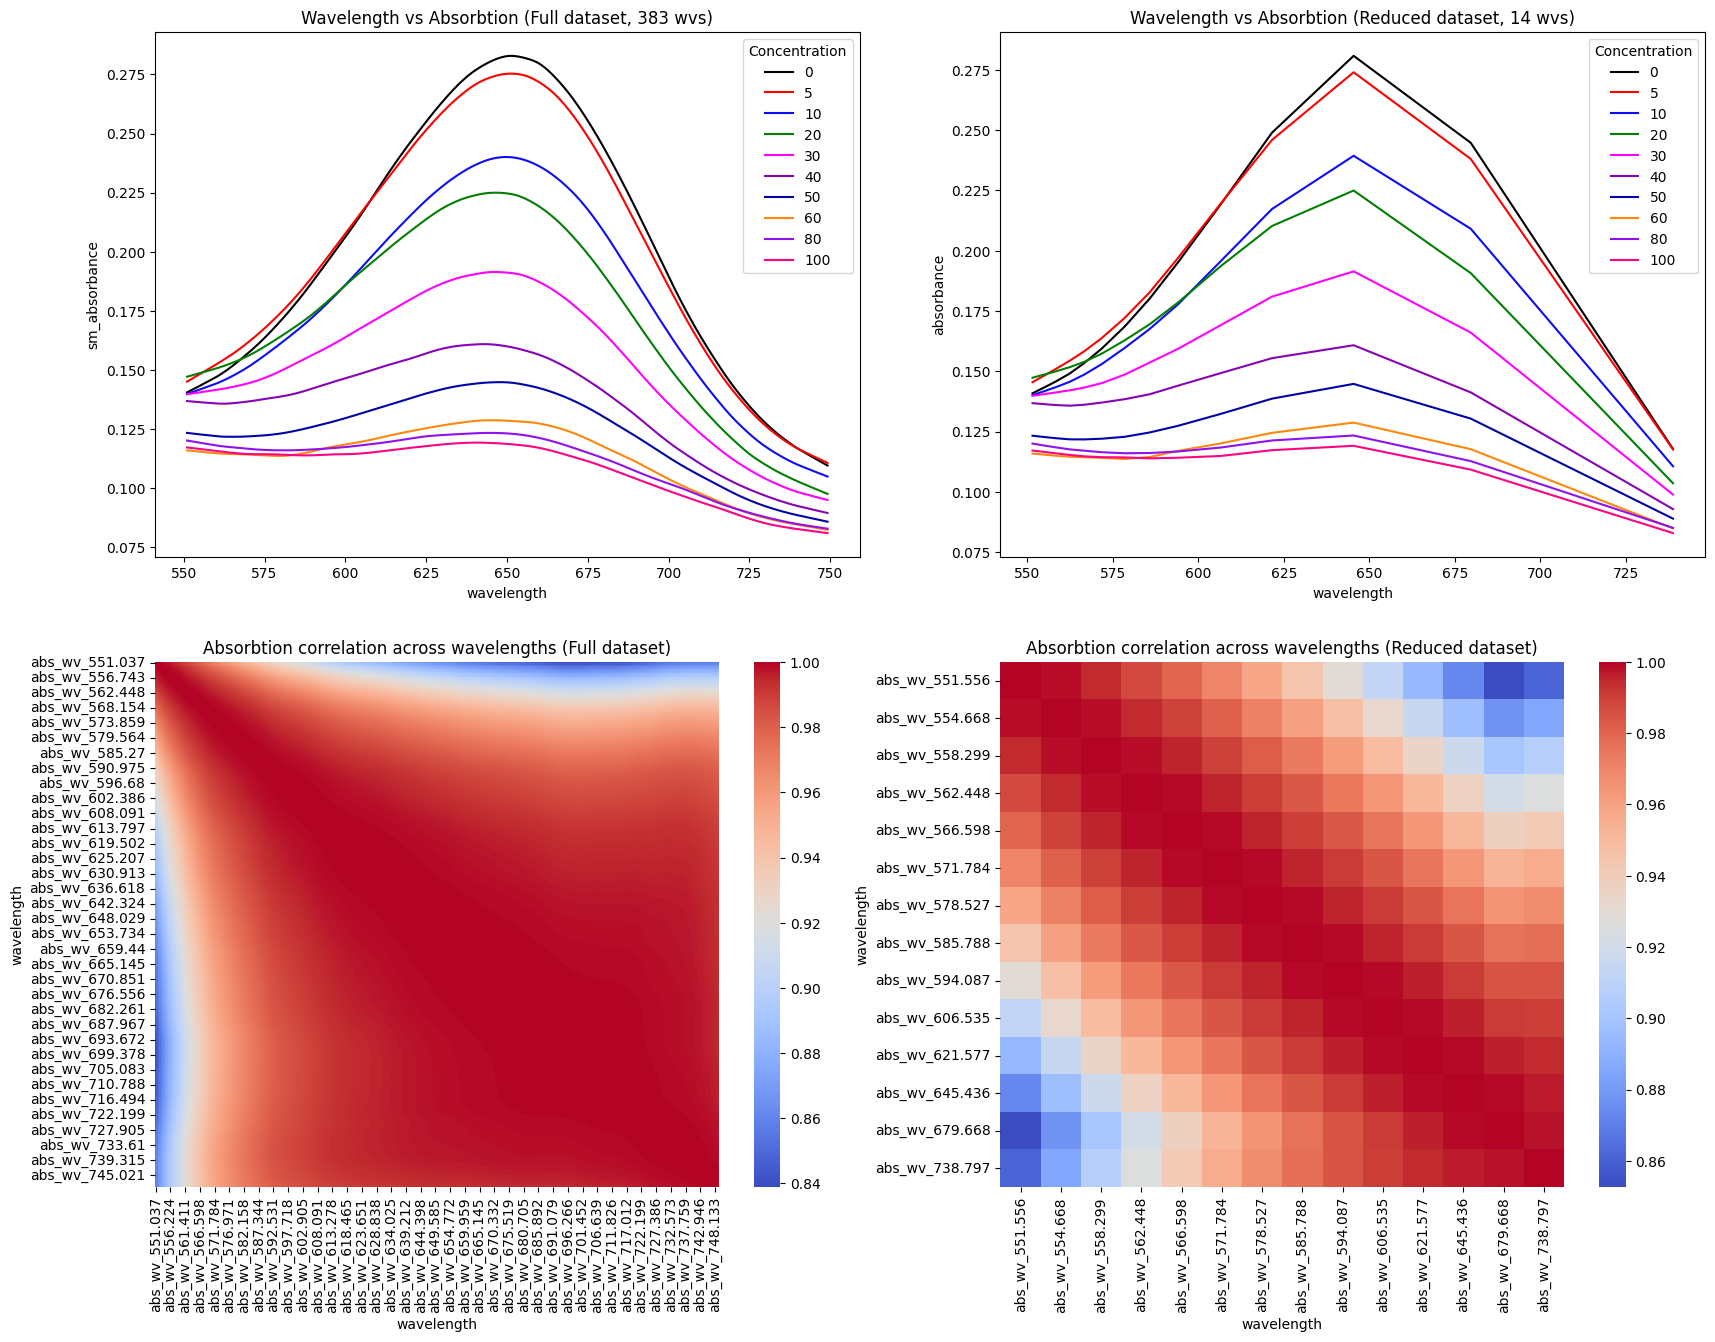

In [12]:
# compare the original plot and the "reduced" plot
# convert the data to long format
long_data = X_filt.copy(deep=True)
long_data['Concentration'] = y
long_data = long_data.melt(id_vars='Concentration', var_name='wavelength', value_name='absorbance')
long_data['wavelength'] = long_data['wavelength'].str.replace('abs_wv_', '').astype(float)

# create 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten()
webcolors = ["#000000","#FF0001","#0D0CF9","#017F03","#FF02FF","#8604B4","#0203A6","#FF870C","#9011EE","#FF0381"]
sns.lineplot(data=data, x="wavelength", y="sm_absorbance", hue="Concentration", palette=webcolors, ax=axs[0])
axs[0].set_title(f"Wavelength vs Absorbtion (Full dataset, {len(data)//len(y)} wvs)")
sns.lineplot(data=long_data, x="wavelength", y="absorbance", hue="Concentration", palette=webcolors, ax=axs[1])
axs[1].set_title(f"Wavelength vs Absorbtion (Reduced dataset, {len(long_data)//len(y)} wvs)")
# now compare the correlation heatmaps
sns.heatmap(X[sorted(X.columns)].corr(), cmap='coolwarm', ax=axs[2])
axs[2].set_title("Absorbtion correlation across wavelengths (Full dataset)")
sns.heatmap(X_filt[sorted(X_filt.columns)].corr(), cmap='coolwarm', ax=axs[3])
axs[3].set_title("Absorbtion correlation across wavelengths (Reduced dataset)")
plt.show()

### Iteratively add additional features and measure the drop in MSE

In [13]:
# first we have to fix the names of the columns
# we want to replace all '.' with '_' in the column names
X_filt.columns = X_filt.columns.str.replace('.', '_')

Xy_filt = X_filt.copy(deep=True)
Xy_filt['Concentration'] = y

def determine_best_feat_2_add(current_feats, Xy_filt):
    cur_formula = 'Concentration ~ ' + ' + '.join(current_feats)
    
    # first fit the model with the current features
    model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
    results = model.fit()
    cur_mse = results.mse_resid
    
    mse_map = {}
    for col in Xy_filt.columns:
        if col == 'Concentration' or col in current_feats:
            continue
        model = sm.OLS.from_formula(f'{cur_formula} + {col}', data=Xy_filt)
        results = model.fit()
        #print(f'{cur_formula} + {col}', results.mse_resid)
        mse_map[col] = results.mse_resid
    best_feat = min(mse_map, key=mse_map.get)
    if mse_map[best_feat] < cur_mse:
        return best_feat, mse_map[best_feat]
    else:
        return None, None

model = sm.OLS.from_formula(f'Concentration ~ {kept_features[0].replace(".","_")}', data=Xy_filt)
results = model.fit()

data_list = [{'n_feats':1, 'best_feat':kept_features[0].replace(".","_"), 'best_mse':results.mse_resid}]
cur_feats = [data_list[0]['best_feat']]
for n_feats in range(2, 10):
    best_feat, best_mse = determine_best_feat_2_add(cur_feats, Xy_filt)
    if best_feat is None:
        break
    cur_feats.append(best_feat)
    data_list.append({'n_feats':n_feats, 'best_feat':best_feat, 'best_mse':best_mse})
    print(n_feats, best_feat, best_mse)
pd.DataFrame(data_list)

,n_feats,best_feat,best_mse
0,1,abs_wv_594_087,144.886022


### Try all combinations of k = 1 ... 8 features and see which one has the lowest MSE 

In [14]:
def get_best_comb_feats(k,df):
    best_comb = []
    best_mse = np.inf
    feats = [c for c in df.columns if c != 'Concentration']
    all_data_list = []
    # iterate over all possible combinations of k features
    total_comb = math.comb(len(feats), k)
    for comb in tqdm(combinations(feats, k), total=total_comb):
        cur_formula = 'Concentration ~ ' + ' + '.join(comb)
        model = sm.OLS.from_formula(cur_formula, data=df)
        results = model.fit()
        cur_mse = results.mse_resid
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_comb = comb
        all_data_list.append({'n_feats':k, 'comb':comb, 'mse':cur_mse})
    df = pd.DataFrame(all_data_list)
    return best_comb, best_mse, df

data_list = []
all_dfs = []
for k in range(1, 9):
    best_comb, best_mse,df = get_best_comb_feats(k, Xy_filt)
    data_list.append({'n_feats':k, 'best_feats':best_comb, 'best_mse':best_mse})
    all_dfs.append(df)
    print(k, best_comb, best_mse)
att1_data = pd.DataFrame(data_list)

100%|██████████| 14/14 [00:00<00:00, 149.96it/s]


1 ('abs_wv_594_087',) 144.88602198849782


100%|██████████| 91/91 [00:00<00:00, 121.32it/s]


2 ('abs_wv_738_797', 'abs_wv_551_556') 153.3561767636922


100%|██████████| 364/364 [00:03<00:00, 101.34it/s]


3 ('abs_wv_621_577', 'abs_wv_578_527', 'abs_wv_554_668') 64.09019643415489


100%|██████████| 1001/1001 [00:11<00:00, 86.82it/s]


4 ('abs_wv_621_577', 'abs_wv_578_527', 'abs_wv_571_784', 'abs_wv_551_556') 67.5436287809288


100%|██████████| 2002/2002 [00:29<00:00, 67.70it/s]


5 ('abs_wv_566_598', 'abs_wv_679_668', 'abs_wv_562_448', 'abs_wv_558_299', 'abs_wv_554_668') 47.333864965316934


100%|██████████| 3003/3003 [00:49<00:00, 61.11it/s]


6 ('abs_wv_566_598', 'abs_wv_679_668', 'abs_wv_562_448', 'abs_wv_558_299', 'abs_wv_554_668', 'abs_wv_551_556') 11.532531026701443


100%|██████████| 3432/3432 [01:20<00:00, 42.64it/s]


7 ('abs_wv_594_087', 'abs_wv_738_797', 'abs_wv_566_598', 'abs_wv_562_448', 'abs_wv_558_299', 'abs_wv_554_668', 'abs_wv_551_556') 0.6227467838203804


100%|██████████| 3003/3003 [01:10<00:00, 42.87it/s]

8 ('abs_wv_594_087', 'abs_wv_606_535', 'abs_wv_621_577', 'abs_wv_645_436', 'abs_wv_738_797', 'abs_wv_679_668', 'abs_wv_554_668', 'abs_wv_551_556') 0.00030548851445682406


In [15]:
# sns.boxplot(data=pd.concat(all_dfs), x='n_feats', y='mse')

## attempt 2: sort wavelengths by variance

In [16]:
# now fit the sv linear regression models for all the features and map each feature to the MSE
var_map = {}
for col in tqdm([c for c in wide_data.columns if c != 'Concentration']):
    var_map[col] = wide_data[col].var()
# sort the features by the variance descending
sorted_features = sorted(mse_map, key=var_map.get, reverse=True)
thresh = 0.999 # 1 - 1e-4
kept_features = []
for test_feat in sorted_features:
    for feat in kept_features:
        if corr_matrix.loc[test_feat, feat] > thresh:
            break
    else:
        kept_features.append(test_feat)
print(kept_features)

100%|██████████| 383/383 [00:00<00:00, 2938.33it/s]

['abs_wv_652.178', 'abs_wv_627.801', 'abs_wv_687.967', 'abs_wv_609.129', 'abs_wv_596.162', 'abs_wv_587.344', 'abs_wv_580.083', 'abs_wv_573.34', 'abs_wv_567.635', 'abs_wv_727.386', 'abs_wv_562.967', 'abs_wv_558.817', 'abs_wv_555.187', 'abs_wv_552.075', 'abs_wv_744.502']


In [17]:
print(len(kept_features), "abs_wv_652.178" in kept_features)

15 True


In [18]:
X_filt = X[kept_features]
print(X_filt.shape)

(10, 15)


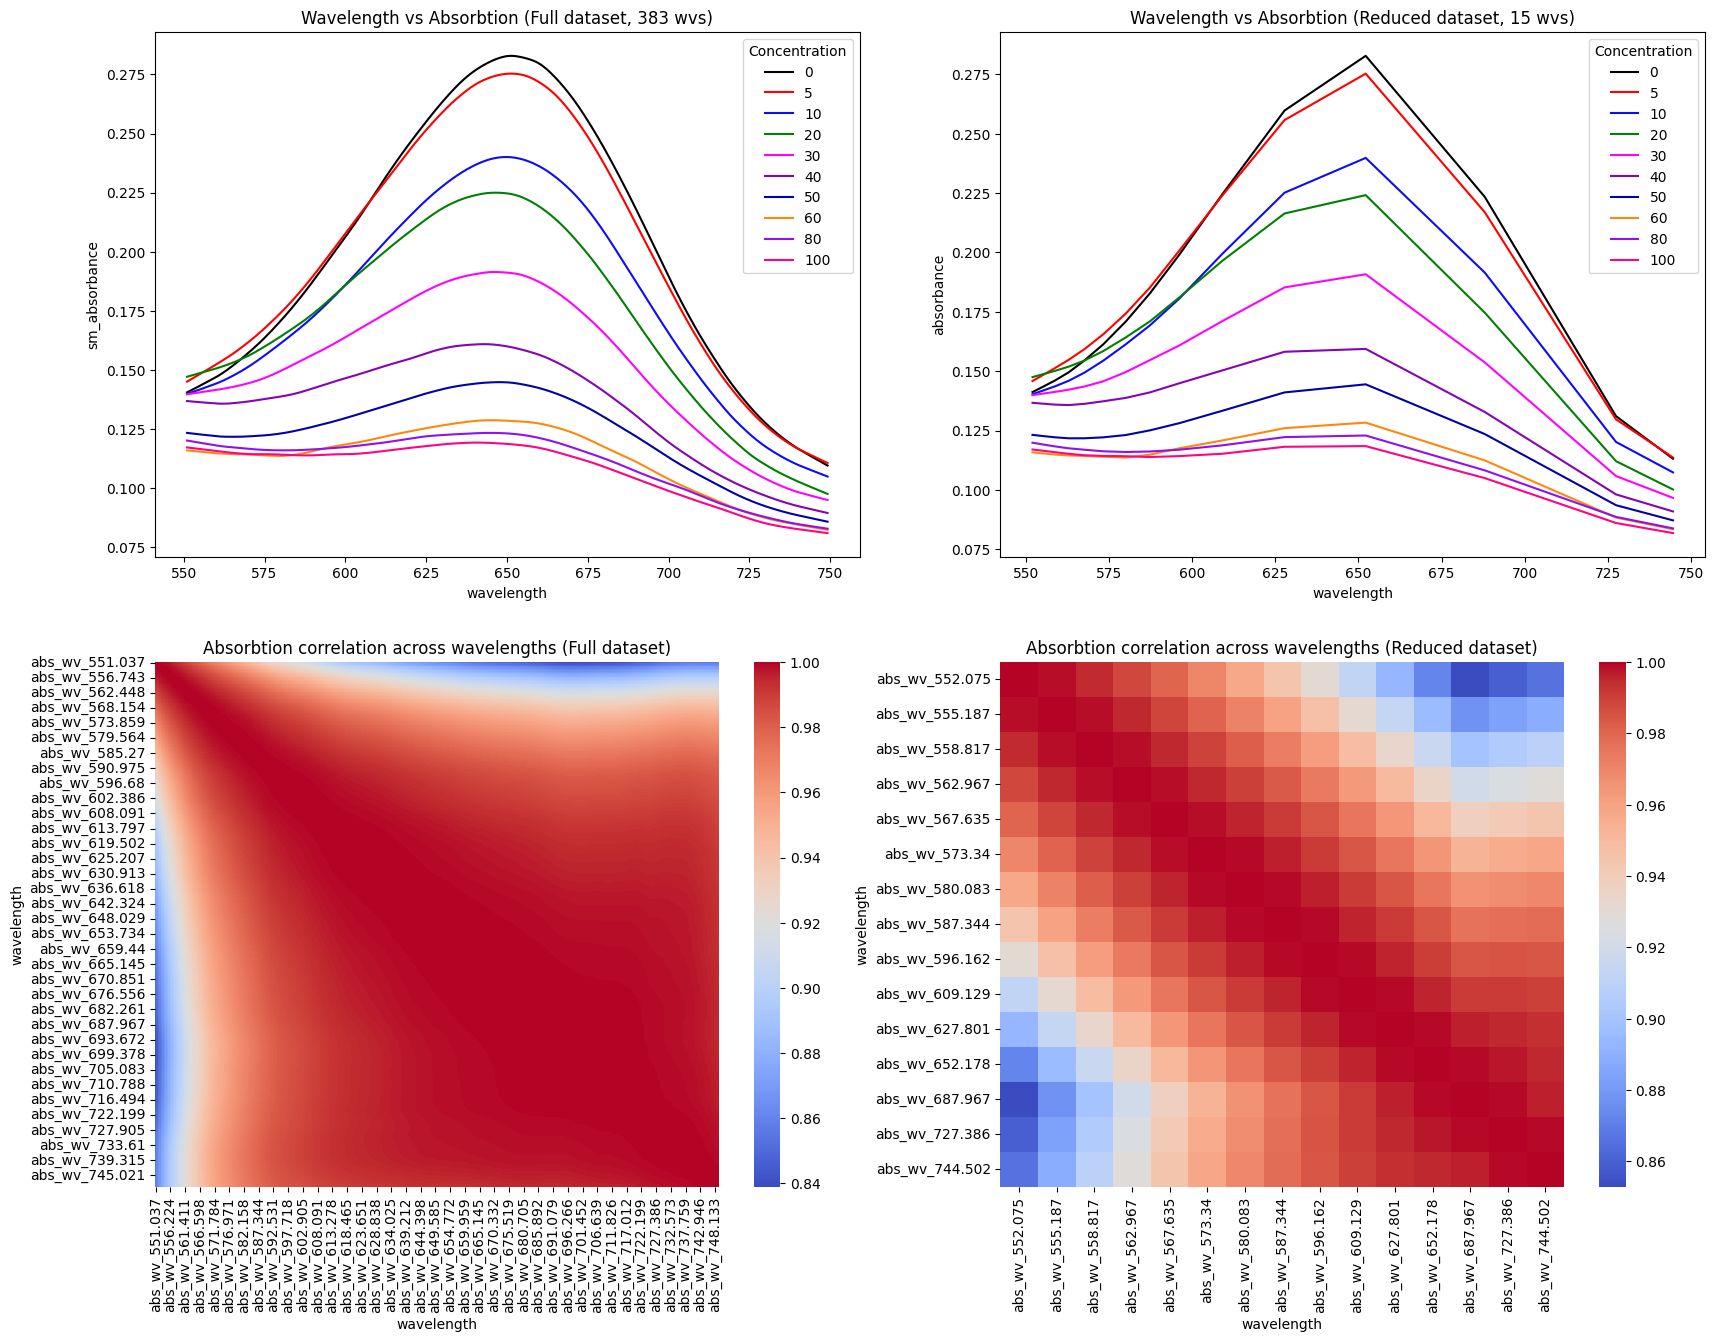

In [19]:
long_data = X_filt.copy(deep=True)
long_data['Concentration'] = y
long_data = long_data.melt(id_vars='Concentration', var_name='wavelength', value_name='absorbance')
long_data['wavelength'] = long_data['wavelength'].str.replace('abs_wv_', '').astype(float)

# create 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten()
webcolors = ["#000000","#FF0001","#0D0CF9","#017F03","#FF02FF","#8604B4","#0203A6","#FF870C","#9011EE","#FF0381"]
sns.lineplot(data=data, x="wavelength", y="sm_absorbance", hue="Concentration", palette=webcolors, ax=axs[0])
axs[0].set_title(f"Wavelength vs Absorbtion (Full dataset, {len(data)//len(y)} wvs)")
sns.lineplot(data=long_data, x="wavelength", y="absorbance", hue="Concentration", palette=webcolors, ax=axs[1])
axs[1].set_title(f"Wavelength vs Absorbtion (Reduced dataset, {len(long_data)//len(y)} wvs)")
# now compare the correlation heatmaps
sns.heatmap(X[sorted(X.columns)].corr(), cmap='coolwarm', ax=axs[2])
axs[2].set_title("Absorbtion correlation across wavelengths (Full dataset)")
sns.heatmap(X_filt[sorted(X_filt.columns)].corr(), cmap='coolwarm', ax=axs[3])
axs[3].set_title("Absorbtion correlation across wavelengths (Reduced dataset)")

# save fig to svg
plt.savefig('p02_data_proc_high_var_corr_red.svg')

plt.show()

### Iteratively add additional features and measure the drop in MSE

In [20]:
# first we have to fix the names of the columns
# we want to replace all '.' with '_' in the column names
X_filt.columns = X_filt.columns.str.replace('.', '_')

Xy_filt = X_filt.copy(deep=True)
Xy_filt['Concentration'] = y

def determine_best_feat_2_add(current_feats, Xy_filt):
    cur_formula = 'Concentration ~ ' + ' + '.join(current_feats)
    
    # first fit the model with the current features
    model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
    results = model.fit()
    cur_mse = results.mse_resid
    
    mse_map = {}
    for col in Xy_filt.columns:
        if col == 'Concentration' or col in current_feats:
            continue
        model = sm.OLS.from_formula(f'{cur_formula} + {col}', data=Xy_filt)
        results = model.fit()
        #print(f'{cur_formula} + {col}', results.mse_resid)
        mse_map[col] = results.mse_resid
    best_feat = min(mse_map, key=mse_map.get)
    if mse_map[best_feat] < cur_mse:
        return best_feat, mse_map[best_feat]
    else:
        return None, None

model = sm.OLS.from_formula('Concentration ~ sm_absorbance', data=wv_highest_variance)
results = model.fit()

data_list = [{'n_feats':1, 'best_feat':kept_features[0].replace(".","_"), 'best_mse':results.mse_resid}]
cur_feats = [data_list[0]['best_feat']]
for n_feats in range(2, 10):
    best_feat, best_mse = determine_best_feat_2_add(cur_feats, Xy_filt)
    if best_feat is None:
        break
    cur_feats.append(best_feat)
    data_list.append({'n_feats':n_feats, 'best_feat':best_feat, 'best_mse':best_mse})
    print(n_feats, best_feat, best_mse)
pd.DataFrame(data_list)

2 abs_wv_552_075 157.21711142863245
3 abs_wv_580_083 74.86349520256086
4 abs_wv_627_801 68.79118867583193
5 abs_wv_744_502 34.77832919930119
6 abs_wv_727_386 15.673297292516011


,n_feats,best_feat,best_mse
0,1,abs_wv_652_178,168.790648
1,2,abs_wv_552_075,157.217111
2,3,abs_wv_580_083,74.863495
3,4,abs_wv_627_801,68.791189
4,5,abs_wv_744_502,34.778329
5,6,abs_wv_727_386,15.673297


### Try all combinations of k = 1 ... 8 features and see which one has the lowest MSE 

In [21]:
def get_best_comb_feats(k,df):
    best_comb = []
    best_mse = np.inf
    feats = [c for c in df.columns if c != 'Concentration']
    
    # iterate over all possible combinations of k features
    total_comb = math.comb(len(feats), k)
    for comb in tqdm(combinations(feats, k), total=total_comb):
        cur_formula = 'Concentration ~ ' + ' + '.join(comb)
        model = sm.OLS.from_formula(cur_formula, data=df)
        results = model.fit()
        cur_mse = results.mse_resid
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_comb = comb
    return best_comb, best_mse

data_list = []
for k in range(1, 9):
    best_comb, best_mse = get_best_comb_feats(k, Xy_filt)
    data_list.append({'n_feats':k, 'best_feats':best_comb, 'best_mse':best_mse})
    print(k, best_comb, best_mse)
att2_data = pd.DataFrame(data_list)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 118.82it/s]


1 ('abs_wv_596_162',) 145.0000248024146


100%|██████████| 105/105 [00:00<00:00, 105.11it/s]


2 ('abs_wv_687_967', 'abs_wv_552_075') 154.91359654336065


100%|██████████| 455/455 [00:04<00:00, 104.57it/s]


3 ('abs_wv_627_801', 'abs_wv_580_083', 'abs_wv_555_187') 57.75105825188447


100%|██████████| 1365/1365 [00:15<00:00, 88.92it/s]


4 ('abs_wv_609_129', 'abs_wv_580_083', 'abs_wv_552_075', 'abs_wv_744_502') 59.19357567049356


100%|██████████| 3003/3003 [00:47<00:00, 63.02it/s]


5 ('abs_wv_652_178', 'abs_wv_580_083', 'abs_wv_727_386', 'abs_wv_552_075', 'abs_wv_744_502') 14.626361216988663


100%|██████████| 5005/5005 [01:30<00:00, 55.18it/s]


6 ('abs_wv_596_162', 'abs_wv_573_34', 'abs_wv_727_386', 'abs_wv_555_187', 'abs_wv_552_075', 'abs_wv_744_502') 2.9279742966429114


100%|██████████| 6435/6435 [02:29<00:00, 43.13it/s]


7 ('abs_wv_687_967', 'abs_wv_573_34', 'abs_wv_727_386', 'abs_wv_562_967', 'abs_wv_555_187', 'abs_wv_552_075', 'abs_wv_744_502') 0.1261134493195656


100%|██████████| 6435/6435 [04:24<00:00, 24.35it/s]

8 ('abs_wv_652_178', 'abs_wv_627_801', 'abs_wv_687_967', 'abs_wv_596_162', 'abs_wv_587_344', 'abs_wv_573_34', 'abs_wv_562_967', 'abs_wv_552_075') 5.826029992368333e-10


## attempt 3: Collapse absorbtions every 15 nm

In [22]:
## attempt 3: collapse wavelengths every 15 nm
# now fit the sv linear regression models for all the features and map each feature to the MSE
collapsed_df = wide_data[["Concentration"]].copy(deep=True)
for wv_start in range(550, 750, 15):
    wv_end = wv_start + 15
    wv_cols = [c for c in wide_data.columns if "_" in c and wv_start <= float(c.split('_')[-1]) < wv_end]
    collapsed_df[f"abs_wv_{wv_start+5}"] = wide_data[wv_cols].mean(axis=1)

In [23]:
X_filt = collapsed_df.drop(columns='Concentration')

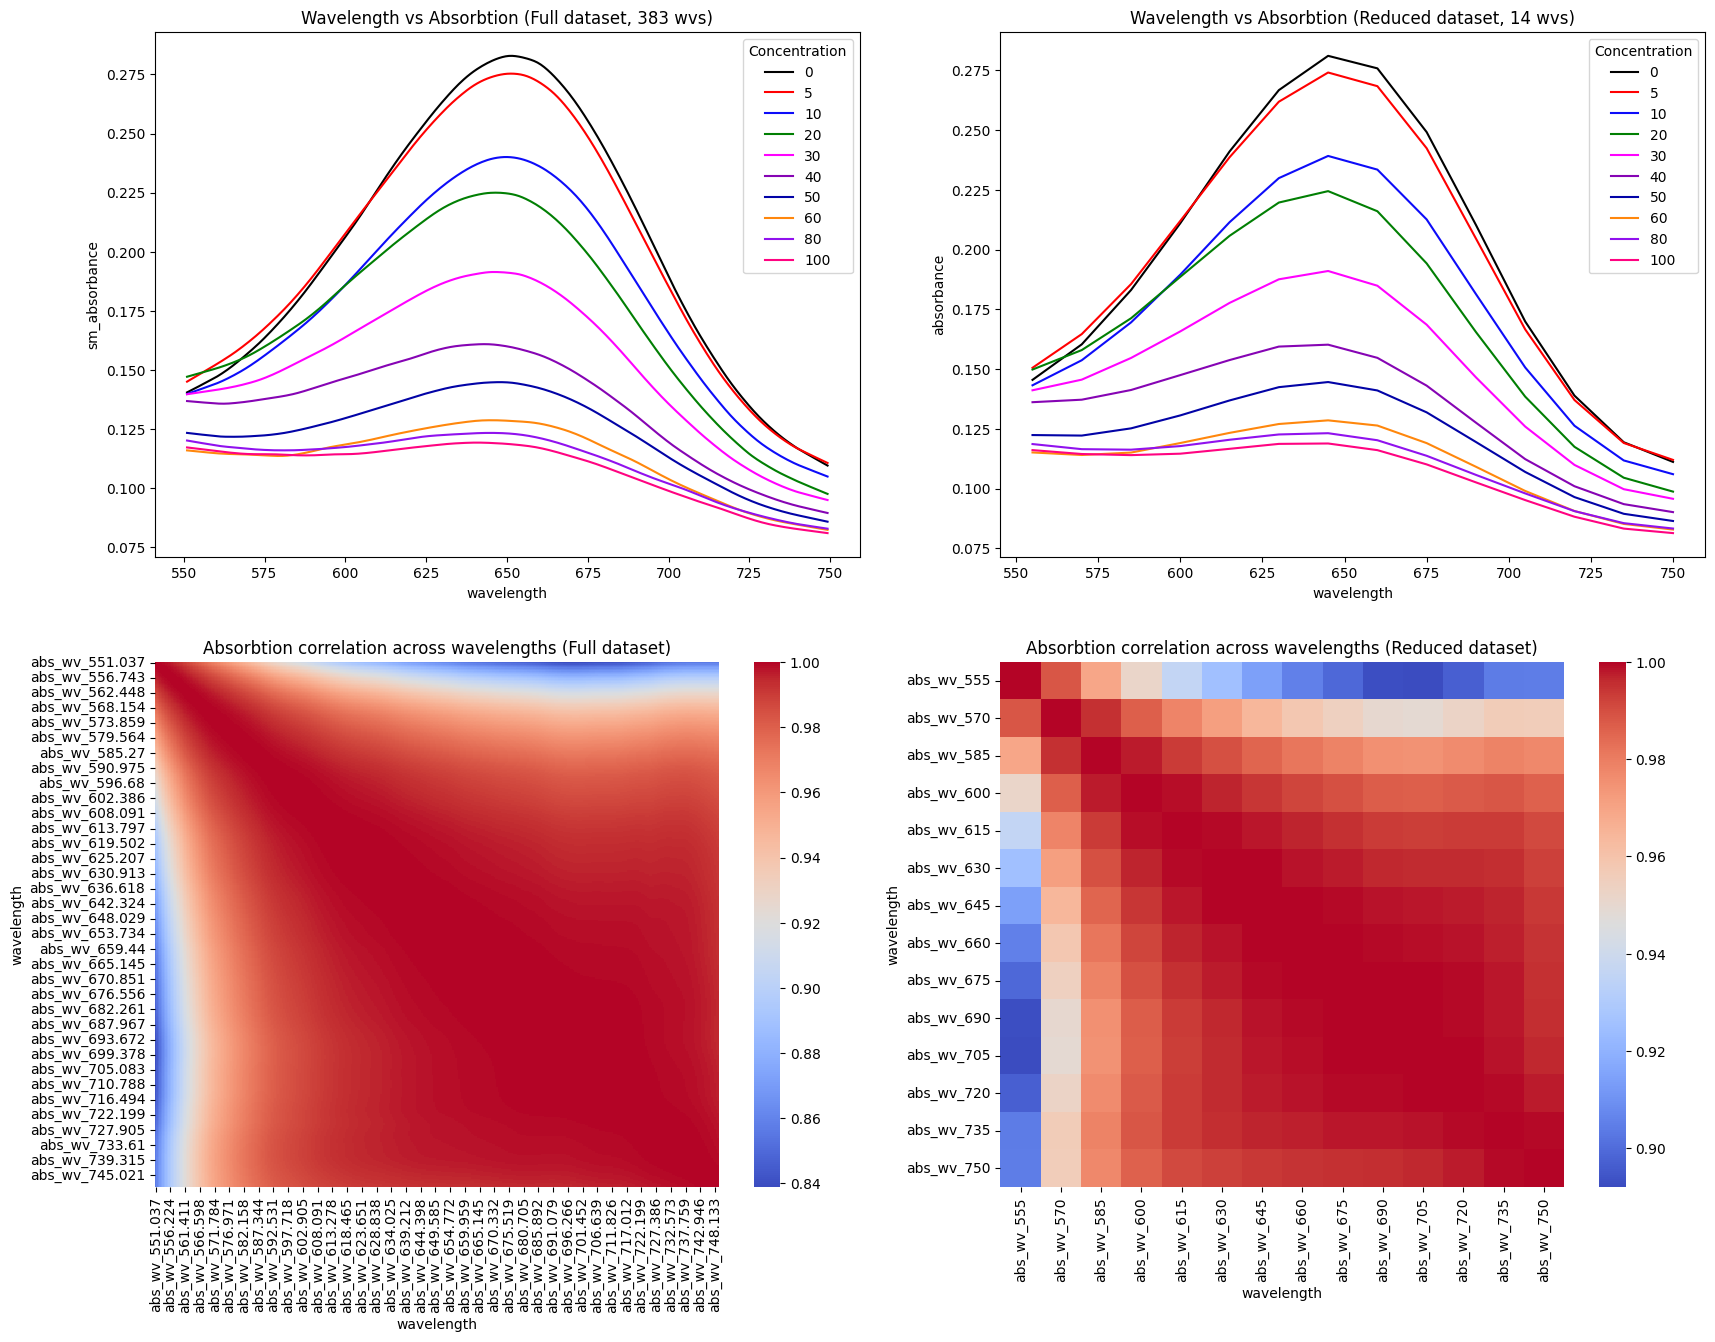

In [24]:
long_data = X_filt.copy(deep=True)
long_data['Concentration'] = y
long_data = long_data.melt(id_vars='Concentration', var_name='wavelength', value_name='absorbance')
long_data['wavelength'] = long_data['wavelength'].str.replace('abs_wv_', '').astype(float)

# create 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten()
webcolors = ["#000000","#FF0001","#0D0CF9","#017F03","#FF02FF","#8604B4","#0203A6","#FF870C","#9011EE","#FF0381"]
sns.lineplot(data=data, x="wavelength", y="sm_absorbance", hue="Concentration", palette=webcolors, ax=axs[0])
axs[0].set_title(f"Wavelength vs Absorbtion (Full dataset, {len(data)//len(y)} wvs)")
sns.lineplot(data=long_data, x="wavelength", y="absorbance", hue="Concentration", palette=webcolors, ax=axs[1])
axs[1].set_title(f"Wavelength vs Absorbtion (Reduced dataset, {len(long_data)//len(y)} wvs)")
# now compare the correlation heatmaps
sns.heatmap(X[sorted(X.columns)].corr(), cmap='coolwarm', ax=axs[2])
axs[2].set_title("Absorbtion correlation across wavelengths (Full dataset)")
sns.heatmap(X_filt[sorted(X_filt.columns)].corr(), cmap='coolwarm', ax=axs[3])
axs[3].set_title("Absorbtion correlation across wavelengths (Reduced dataset)")
plt.show()

In [25]:
### Iteratively add additional features and measure the drop in MSE
# first we have to fix the names of the columns
# we want to replace all '.' with '_' in the column names
X_filt.columns = X_filt.columns.str.replace('.', '_')

Xy_filt = X_filt.copy(deep=True)
Xy_filt['Concentration'] = y

def determine_best_feat_2_add(current_feats, Xy_filt):
    if len(current_feats) > 0:
        cur_formula = 'Concentration ~ ' + ' + '.join(current_feats)
        
        # first fit the model with the current features
        model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
        results = model.fit()
        cur_mse = results.mse_resid
    else:
        cur_formula = 'Concentration ~ 1'
        cur_mse = np.inf
    
    mse_map = {}
    for col in Xy_filt.columns:
        if col == 'Concentration' or col in current_feats:
            continue
        model = sm.OLS.from_formula(f'{cur_formula} + {col}', data=Xy_filt)
        results = model.fit()
        #print(f'{cur_formula} + {col}', results.mse_resid)
        mse_map[col] = results.mse_resid
    best_feat = min(mse_map, key=mse_map.get)
    if mse_map[best_feat] < cur_mse:
        return best_feat, mse_map[best_feat]
    else:
        return None, None

data_list = []
cur_feats = []
for n_feats in range(1, 10):
    best_feat, best_mse = determine_best_feat_2_add(cur_feats, Xy_filt)
    if best_feat is None:
        break
    cur_feats.append(best_feat)
    data_list.append({'n_feats':n_feats, 'best_feat':best_feat, 'best_mse':best_mse})
    print(n_feats, best_feat, best_mse)
pd.DataFrame(data_list)

1 abs_wv_600 145.1052248402534


,n_feats,best_feat,best_mse
0,1,abs_wv_600,145.105225


In [26]:
### Try all combinations of k = 1 ... 9 features and see which one has the lowest MSE 
def get_best_comb_feats(k,df):
    best_comb = []
    best_mse = np.inf
    feats = [c for c in df.columns if c != 'Concentration']
    
    # iterate over all possible combinations of k features
    total_comb = math.comb(len(feats), k)
    for comb in tqdm(combinations(feats, k), total=total_comb):
        cur_formula = 'Concentration ~ ' + ' + '.join(comb)
        model = sm.OLS.from_formula(cur_formula, data=df)
        results = model.fit()
        cur_mse = results.mse_resid
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_comb = comb
    return best_comb, best_mse

## skipping this section since it adds ~30 min of runtime to the notebook
## and the results are not that interesting
data_list = []
for k in range(1, 9):
    best_comb, best_mse = get_best_comb_feats(k, Xy_filt)
    data_list.append({'n_feats':k, 'best_feats':best_comb, 'best_mse':best_mse})
    print(k, best_comb, best_mse)
att3_data = pd.DataFrame(data_list)

100%|██████████| 14/14 [00:00<00:00, 78.29it/s]


1 ('abs_wv_600',) 145.1052248402534


100%|██████████| 91/91 [00:01<00:00, 61.85it/s]


2 ('abs_wv_555', 'abs_wv_735') 158.21028289020092


100%|██████████| 364/364 [00:07<00:00, 49.31it/s]


3 ('abs_wv_555', 'abs_wv_585', 'abs_wv_630') 71.71556589952777


100%|██████████| 1001/1001 [00:23<00:00, 41.77it/s]


4 ('abs_wv_555', 'abs_wv_585', 'abs_wv_675', 'abs_wv_690') 23.081572431875323


100%|██████████| 2002/2002 [00:55<00:00, 36.01it/s]


5 ('abs_wv_555', 'abs_wv_570', 'abs_wv_675', 'abs_wv_720', 'abs_wv_735') 10.076704202763434


100%|██████████| 3003/3003 [01:35<00:00, 31.52it/s]


6 ('abs_wv_555', 'abs_wv_570', 'abs_wv_615', 'abs_wv_645', 'abs_wv_720', 'abs_wv_735') 0.31321414470895736


100%|██████████| 3432/3432 [02:02<00:00, 28.09it/s]


7 ('abs_wv_555', 'abs_wv_570', 'abs_wv_615', 'abs_wv_630', 'abs_wv_645', 'abs_wv_720', 'abs_wv_735') 0.006996395900085274


100%|██████████| 3003/3003 [01:57<00:00, 25.62it/s]

8 ('abs_wv_555', 'abs_wv_570', 'abs_wv_615', 'abs_wv_630', 'abs_wv_645', 'abs_wv_705', 'abs_wv_720', 'abs_wv_735') 7.24451521703522e-05


Similar to the results from attempt 2 ... effect is only slightly stronger, so will proceed with attempt 2 collapse for future work.

# Restate the feature reduction step

From the previous section we established that some feature reduction is necessary to reduce the model colinearity and make the search for the optimal k-coefficient model tractable.

The approach I settled on for reducing the colinearity between the features was to rank the wavelengths by variance absorbtion. Then remove wavelengths that correlated with a previously retained wavelength of higher variance at a pearson correlation threshold of 0.999 or greater. 

In [27]:
# redo the feature reduction step according to what was determined earlier
var_map = {}
for col in tqdm([c for c in wide_data.columns if c != 'Concentration']):
    var_map[col] = wide_data[col].var()
# sort the features by the variance descending
sorted_features = sorted(mse_map, key=var_map.get, reverse=True)
thresh = 0.999 # 1 - 1e-4
kept_features = []
for test_feat in sorted_features:
    for feat in kept_features:
        if corr_matrix.loc[test_feat, feat] > thresh:
            break
    else:
        kept_features.append(test_feat)

X = wide_data.drop(columns='Concentration')
X_filt = X[kept_features]

Xy_filt = X_filt.copy(deep=True)
Xy_filt['Concentration'] = y

# replace the "." with "_" in the column names
Xy_filt.columns = Xy_filt.columns.str.replace('.', '_')

100%|██████████| 383/383 [00:00<00:00, 3034.41it/s]


In [28]:
print(len(kept_features))

15


In [29]:
long_data = X_filt.copy(deep=True)
long_data['Concentration'] = y
long_data = long_data.melt(id_vars='Concentration', var_name='wavelength', value_name='absorbance')
long_data['wavelength'] = long_data['wavelength'].str.replace('abs_wv_', '').astype(float)

In [30]:
feats = att2_data['best_feats'].values[0]
cur_formula = 'Concentration ~ ' + ' + '.join(feats)
model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
results = model.fit()
print("train MSE:",results.mse_resid)

train MSE: 145.0000248024146


In [31]:
att2_data['best_feats']

0                                    (abs_wv_596_162,)
1                     (abs_wv_687_967, abs_wv_552_075)
2     (abs_wv_627_801, abs_wv_580_083, abs_wv_555_187)
3    (abs_wv_609_129, abs_wv_580_083, abs_wv_552_07...
4    (abs_wv_652_178, abs_wv_580_083, abs_wv_727_38...
5    (abs_wv_596_162, abs_wv_573_34, abs_wv_727_386...
6    (abs_wv_687_967, abs_wv_573_34, abs_wv_727_386...
7    (abs_wv_652_178, abs_wv_627_801, abs_wv_687_96...
Name: best_feats, dtype: object

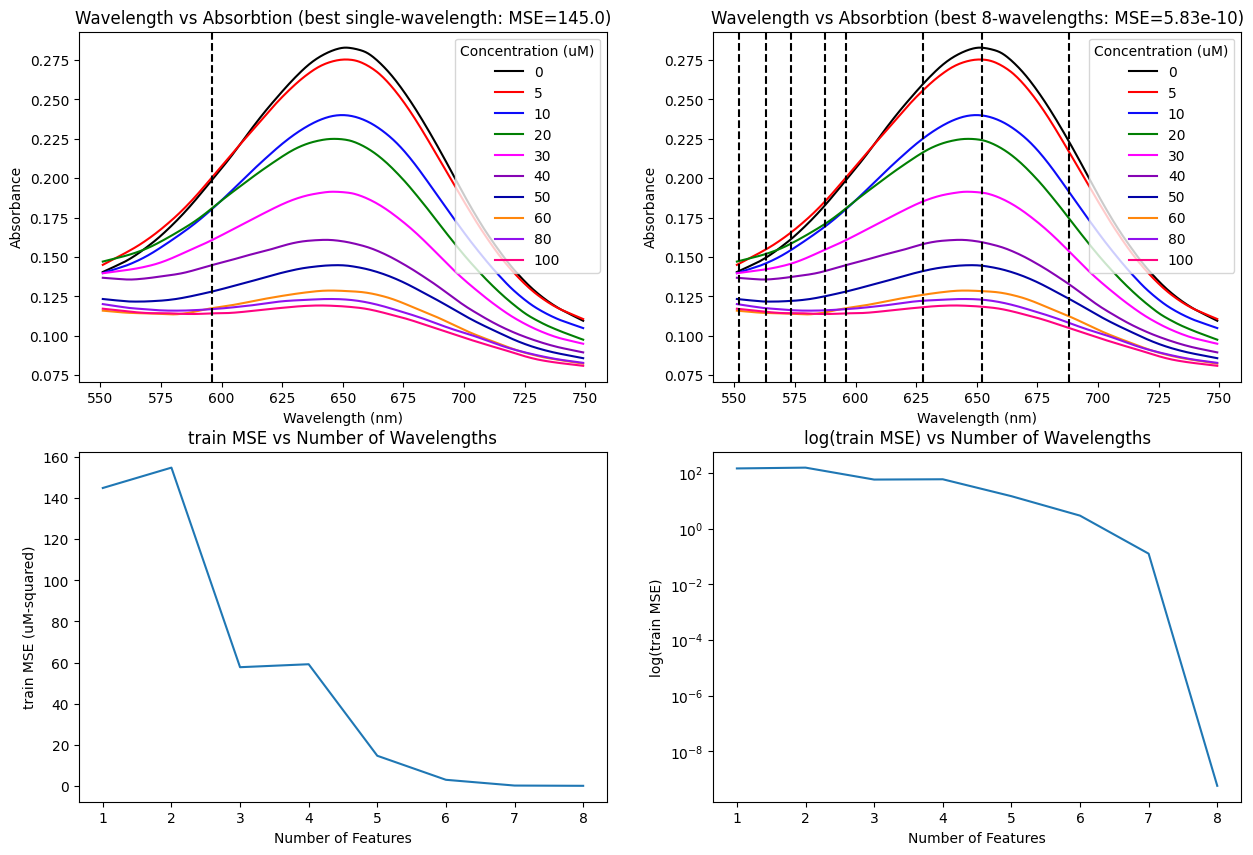

In [32]:
# build lineplot of decreasing MSE when features are added 
# create 2 plots side-by-side
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

feats = att2_data['best_feats'].values[0]
cur_formula = 'Concentration ~ ' + ' + '.join(feats)
model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
results = model.fit()

sns.lineplot(data=data, x="wavelength", y="sm_absorbance", hue="Concentration", palette=webcolors, ax=axs[0])
axs[0].set_title(f"Wavelength vs Absorbtion (best single-wavelength: MSE={round(results.mse_resid,2)})")
# change the legend title
axs[0].legend(title="Concentration (uM)")
axs[0].set_xlabel("Wavelength (nm)")
axs[0].set_ylabel("Absorbance")

# for each feature in the model draw a dashed vertical line at that wavelength
for feat in feats:
    wv = float(".".join(feat.split('_')[-2:]))
    axs[0].axvline(wv, color='black', linestyle='--')

feats = att2_data['best_feats'].values[-1]
cur_formula = 'Concentration ~ ' + ' + '.join(feats)
model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
results = model.fit()

sns.lineplot(data=data, x="wavelength", y="sm_absorbance", hue="Concentration", palette=webcolors, ax=axs[1])
axs[1].set_title("Wavelength vs Absorbtion (best {:}-wavelengths: MSE={:.2e})".format(len(feats),results.mse_resid))
axs[1].legend(title="Concentration (uM)")
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("Absorbance")

# for each feature in the model draw a dashed vertical line at that wavelength
for feat in feats:
    wv = float(".".join(feat.split('_')[-2:]))
    axs[1].axvline(wv, color='black', linestyle='--')

sns.lineplot(data=att2_data, x='n_feats', y='best_mse',ax=axs[2])
axs[2].set_title("train MSE vs Number of Wavelengths")
axs[2].set_xlabel("Number of Features")
axs[2].set_ylabel("train MSE (uM-squared)")
sns.lineplot(data=att2_data, x='n_feats', y='best_mse',ax=axs[3])
axs[3].set_title("log(train MSE) vs Number of Wavelengths")
axs[3].set_xlabel("Number of Features")
axs[3].set_ylabel("log(train MSE)")
axs[3].set_yscale('log')

In [59]:
att2_data

,n_feats,best_feats,best_mse
0,1,"(abs_wv_596_162,)",1.450000e+02
1,2,"(abs_wv_687_967, abs_wv_552_075)",1.549136e+02
2,3,"(abs_wv_627_801, abs_wv_580_083, abs_wv_555_187)",5.775106e+01
3,4,"(abs_wv_609_129, abs_wv_580_083, abs_wv_552_07...",5.919358e+01
4,5,"(abs_wv_652_178, abs_wv_580_083, abs_wv_727_38...",1.462636e+01
5,6,"(abs_wv_596_162, abs_wv_573_34, abs_wv_727_386...",2.927974e+00
6,7,"(abs_wv_687_967, abs_wv_573_34, abs_wv_727_386...",1.261134e-01
7,8,"(abs_wv_652_178, abs_wv_627_801, abs_wv_687_96...",5.826030e-10


In [61]:
data.to_csv("colorimetry_data_PS_extracted.csv", index=False)
att2_data.to_csv("best_features_results.csv", index=False)

# Perform a leave-one-out analysis

Since the concentrations range from 0-100 uM we can perform a 8-fold leave-one-out analysis

In [33]:
train_test_results = []
row_is = set(range(10))
for i in range(8):
    for j in range(1,9):
        Xy_filt_train = Xy_filt[Xy_filt.index.isin(row_is - {j})]
        Xy_filt_test = Xy_filt[Xy_filt.index.isin({j})]
        feats = att2_data['best_feats'].values[i]
        cur_formula = 'Concentration ~ ' + ' + '.join(feats)
        model = sm.OLS.from_formula(cur_formula, data=Xy_filt_train)
        results = model.fit()
        #print("train MSE:",results.mse_resid)
        # now generate the predictions for the test set
        y_pred = results.predict(Xy_filt_test)
        # calculate the MSE
        mse = np.mean((y_pred - Xy_filt_test['Concentration'])**2)
        train_test_results.append({"n_features":i+1,'train_MSE':results.mse_resid, 'test_MSE':mse, 'test_index':j})
tr_te_res = pd.DataFrame(train_test_results)

In [34]:
tr_te_res.groupby('n_features').mean()

,train_MSE,test_MSE,test_index
n_features,,,
1,152.996793,1.112498e+02,4.5
2,164.490432,1.359962e+02,4.5
3,58.283252,7.700962e+01,4.5
4,59.649485,9.608435e+01,4.5
5,14.535189,5.411971e+01,4.5
6,3.134112,7.727889e+00,4.5
7,0.164886,3.362163e-01,4.5
8,NaN,1.397736e-07,4.5


In [35]:
tr_te_res.groupby('n_features').agg({'train_MSE':'mean','test_MSE':'median'})

,train_MSE,test_MSE
n_features,,
1,152.996793,7.837874e+01
2,164.490432,7.327667e+01
3,58.283252,3.956611e+01
4,59.649485,5.741883e+01
5,14.535189,2.385676e+01
6,3.134112,7.298422e+00
7,0.164886,3.085178e-01
8,NaN,1.741395e-08


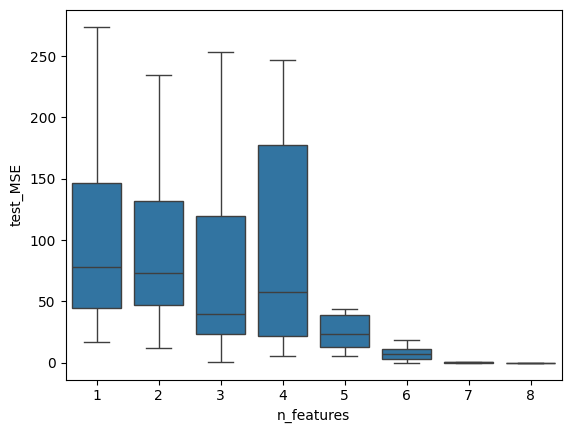

In [36]:

ax = sns.boxplot(x=tr_te_res['n_features'], y = tr_te_res['test_MSE'], showfliers=False)
# change the y-axis to log scale
#ax.set_yscale('log')

# Build Box Plots demonstrating the distribution of feature combination MSEs

In [37]:
def get_best_comb_feats(k,df):
    best_comb = []
    best_mse = np.inf
    feats = [c for c in df.columns if c != 'Concentration']
    all_results = []
    # iterate over all possible combinations of k features
    total_comb = math.comb(len(feats), k)
    for comb in tqdm(combinations(feats, k), total=total_comb):
        cur_formula = 'Concentration ~ ' + ' + '.join(comb)
        model = sm.OLS.from_formula(cur_formula, data=df)
        results = model.fit()
        cur_mse = results.mse_resid
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_comb = comb
        all_results.append({'n_feats':k, 'comb':comb, 'mse':cur_mse})
    return best_comb, best_mse, pd.DataFrame(all_results)

data_list = []
df_list = []
for k in range(1, 9):
    best_comb, best_mse, df = get_best_comb_feats(k, Xy_filt)
    data_list.append({'n_feats':k, 'best_feats':best_comb, 'best_mse':best_mse})
    print(k, best_comb, best_mse)
    df_list.append(df)
att2_data = pd.DataFrame(data_list)
all_dfs_tr_mse = pd.concat(df_list)

100%|██████████| 15/15 [00:00<00:00, 69.23it/s]


1 ('abs_wv_596_162',) 145.0000248024146


100%|██████████| 105/105 [00:01<00:00, 62.60it/s]


2 ('abs_wv_687_967', 'abs_wv_552_075') 154.91359654336065


100%|██████████| 455/455 [00:09<00:00, 50.25it/s]


3 ('abs_wv_627_801', 'abs_wv_580_083', 'abs_wv_555_187') 57.75105825188447


100%|██████████| 1365/1365 [00:32<00:00, 42.41it/s]


4 ('abs_wv_609_129', 'abs_wv_580_083', 'abs_wv_552_075', 'abs_wv_744_502') 59.19357567049356


100%|██████████| 3003/3003 [01:20<00:00, 37.45it/s] 


5 ('abs_wv_652_178', 'abs_wv_580_083', 'abs_wv_727_386', 'abs_wv_552_075', 'abs_wv_744_502') 14.626361216988663


100%|██████████| 5005/5005 [02:35<00:00, 32.10it/s]


6 ('abs_wv_596_162', 'abs_wv_573_34', 'abs_wv_727_386', 'abs_wv_555_187', 'abs_wv_552_075', 'abs_wv_744_502') 2.9279742966429114


100%|██████████| 6435/6435 [03:50<00:00, 27.94it/s]


7 ('abs_wv_687_967', 'abs_wv_573_34', 'abs_wv_727_386', 'abs_wv_562_967', 'abs_wv_555_187', 'abs_wv_552_075', 'abs_wv_744_502') 0.1261134493195656


100%|██████████| 6435/6435 [04:09<00:00, 25.76it/s]

8 ('abs_wv_652_178', 'abs_wv_627_801', 'abs_wv_687_967', 'abs_wv_596_162', 'abs_wv_587_344', 'abs_wv_573_34', 'abs_wv_562_967', 'abs_wv_552_075') 5.826029992368333e-10


In [38]:
all_dfs_tr_mse.groupby('n_feats').agg({'mse':'median'})

,mse
n_feats,
1,171.872247
2,166.035841
3,178.486696
4,156.875465
5,147.179494
6,148.923961
7,152.792298
8,108.262272


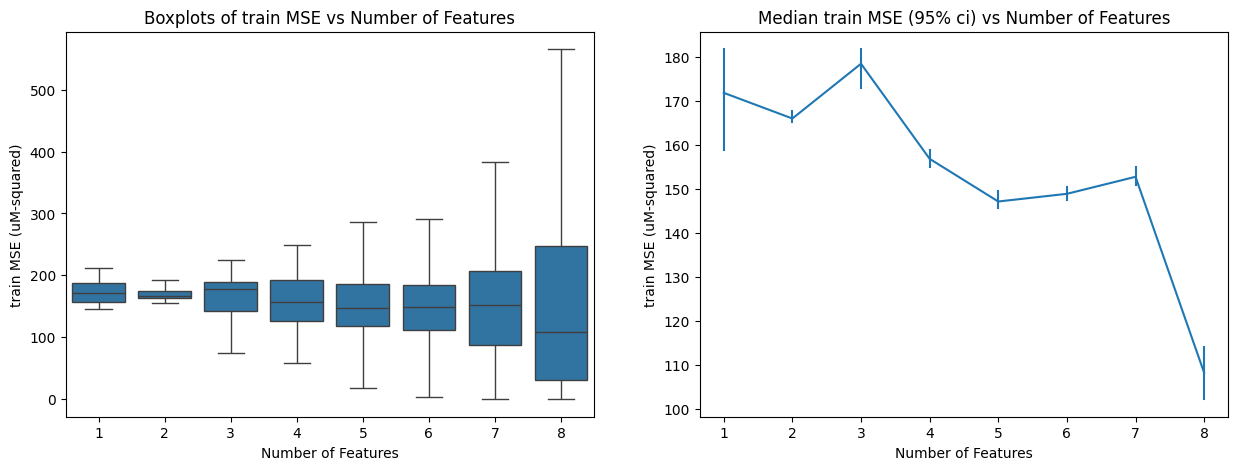

In [39]:
# create 2 subplots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()
sns.boxplot(data=all_dfs_tr_mse, x='n_feats', y='mse', showfliers=False,ax=axs[0])
axs[0].set_title("Boxplots of train MSE vs Number of Features")
axs[0].set_xlabel("Number of Features")
axs[0].set_ylabel("train MSE (uM-squared)")

# seaborn lineplot with mean and sem
sns.lineplot(data=all_dfs_tr_mse, x='n_feats', y='mse', estimator='median', errorbar=("ci",95), seed=RANDOM_SEED, err_style='bars',ax=axs[1])
axs[1].set_title("Median train MSE (95% ci) vs Number of Features")
axs[1].set_xlabel("Number of Features")
axs[1].set_ylabel("train MSE (uM-squared)")

plt.show()

In [40]:
# aggregate the data by the number of features and calculate the 5 number summary of the MSE
all_dfs_tr_mse.groupby('n_feats').agg(
    count=('mse', 'size'),
    min_val=('mse', 'min'),
    q1=('mse', lambda x: x.quantile(0.25)),
    median=('mse', 'median'),
    q3=('mse', lambda x: x.quantile(0.75)),
    max_val=('mse', 'max')
)

,count,min_val,q1,median,q3,max_val
n_feats,,,,,,
1,15,1.450000e+02,157.232372,171.872247,186.944819,261.257309
2,105,1.549136e+02,163.194943,166.035841,174.860381,206.663612
3,455,5.775106e+01,141.926588,178.486696,188.966563,224.841117
4,1365,5.919358e+01,126.116899,156.875465,192.409750,249.446834
5,3003,1.462636e+01,118.377745,147.179494,185.961474,290.085315
6,5005,2.927974e+00,111.726025,148.923961,184.346462,379.944304
7,6435,1.261134e-01,88.154422,152.792298,207.155795,506.725313
8,6435,5.826030e-10,30.984624,108.262272,248.231397,729.625036


In [41]:
# calculate the MWW test against each of the n_feats groups against n_feats=1
baseline = all_dfs_tr_mse[all_dfs_tr_mse['n_feats'] == 1]['mse']
results = []
for n_feats in range(2, 9):
    group = all_dfs_tr_mse[all_dfs_tr_mse['n_feats'] == n_feats]['mse']
    stat, p = mannwhitneyu(baseline, group, alternative='greater')
    results.append({'n_feats':n_feats, 'p-value':p})
    print(f"n_feats={n_feats}, p-value={p}")
orig_pv = pd.DataFrame(results)

n_feats=2, p-value=0.3341433540614399
n_feats=3, p-value=0.29826591507208566
n_feats=4, p-value=0.0333392545625024
n_feats=5, p-value=0.00782170514462842
n_feats=6, p-value=0.009234980379063173
n_feats=7, p-value=0.04904356716193978
n_feats=8, p-value=0.03623029948361611


In [42]:
# calculate the median fold reduction in MSE for each n_feats group against n_feats=1
baseline = all_dfs_tr_mse[all_dfs_tr_mse['n_feats'] == 1]['mse'].median()
results = []
for n_feats in range(2, 9):
    group = all_dfs_tr_mse[all_dfs_tr_mse['n_feats'] == n_feats]['mse'].median()
    results.append({'n_feats':n_feats, 'fold_reduction':baseline/group})
    print(f"n_feats={n_feats}, fold reduction={baseline/group}")
orig_fc = pd.DataFrame(results)

n_feats=2, fold reduction=1.035151481952126
n_feats=3, fold reduction=0.9629414993714694
n_feats=4, fold reduction=1.0955967313001322
n_feats=5, fold reduction=1.1677730490616092
n_feats=6, fold reduction=1.1540939841131694
n_feats=7, fold reduction=1.124875068594902
n_feats=8, fold reduction=1.5875544027092028


In [43]:
tab1 = all_dfs_tr_mse.groupby('n_feats').agg(
    count=('mse', 'size'),
    min_val=('mse', 'min'),
    q1=('mse', lambda x: x.quantile(0.25)),
    median=('mse', 'median'),
    q3=('mse', lambda x: x.quantile(0.75)),
    max_val=('mse', 'max')
).reset_index()
tab1.merge(orig_pv, on='n_feats', how="left").merge(orig_fc, on='n_feats', how="left")

,n_feats,count,min_val,q1,median,q3,max_val,p-value,fold_reduction
0,1,15,1.450000e+02,157.232372,171.872247,186.944819,261.257309,NaN,NaN
1,2,105,1.549136e+02,163.194943,166.035841,174.860381,206.663612,0.334143,1.035151
2,3,455,5.775106e+01,141.926588,178.486696,188.966563,224.841117,0.298266,0.962941
3,4,1365,5.919358e+01,126.116899,156.875465,192.409750,249.446834,0.033339,1.095597
4,5,3003,1.462636e+01,118.377745,147.179494,185.961474,290.085315,0.007822,1.167773
5,6,5005,2.927974e+00,111.726025,148.923961,184.346462,379.944304,0.009235,1.154094
6,7,6435,1.261134e-01,88.154422,152.792298,207.155795,506.725313,0.049044,1.124875
7,8,6435,5.826030e-10,30.984624,108.262272,248.231397,729.625036,0.036230,1.587554


C:\Users\craut\AppData\Local\Temp\ipykernel_20972\973629282.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = all_dfs_tr_mse.groupby('n_feats').apply(lambda x: x.nsmallest(10, 'mse')).reset_index(drop=True)


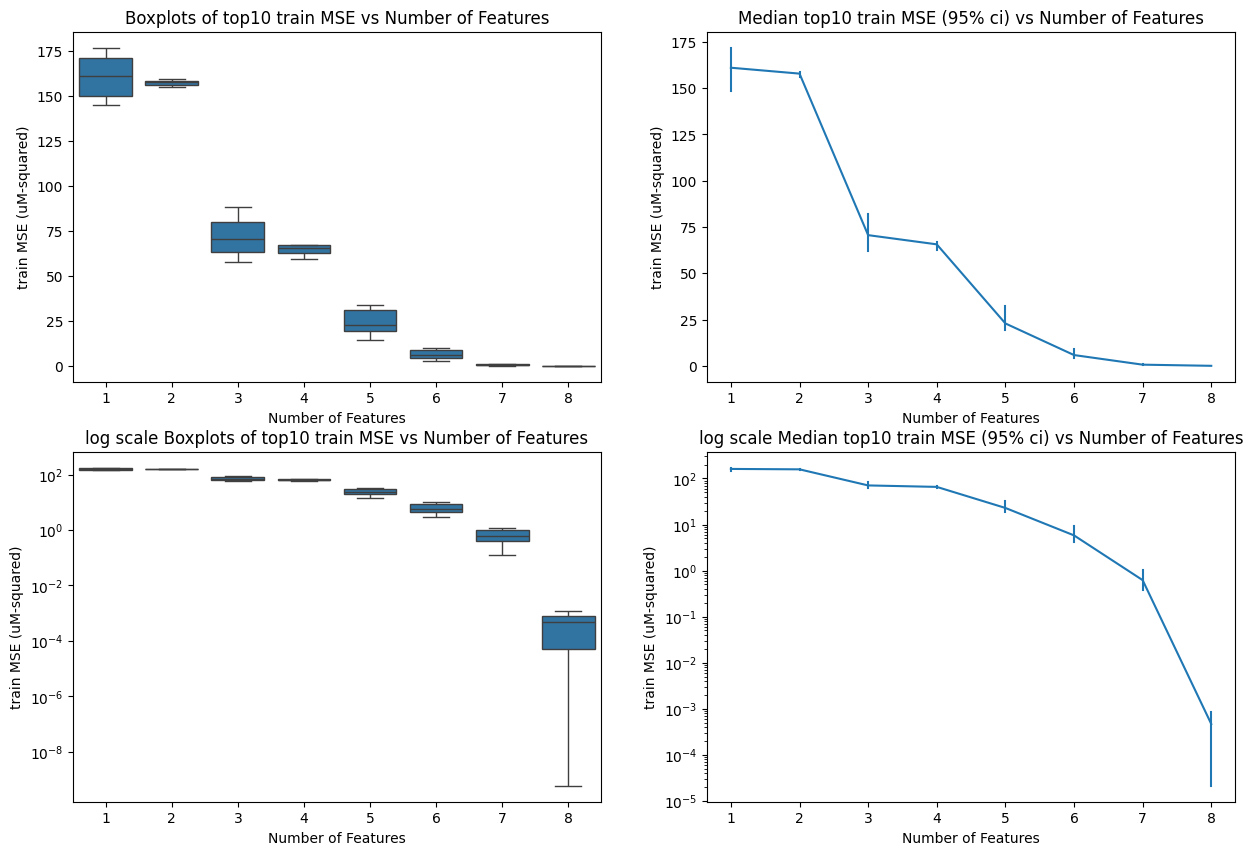

In [66]:
# filter the data to only contain the 10 lowest MSE's for each feature number
filtered_data = all_dfs_tr_mse.groupby('n_feats').apply(lambda x: x.nsmallest(10, 'mse')).reset_index(drop=True)
# create 2 subplots side-by-side
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
sns.boxplot(data=filtered_data, x='n_feats', y='mse', showfliers=False,ax=axs[0])
axs[0].set_title("Boxplots of top10 train MSE vs Number of Features")
axs[0].set_xlabel("Number of Features")
axs[0].set_ylabel("train MSE (uM-squared)")

# seaborn lineplot with mean and sem
sns.lineplot(data=filtered_data, x='n_feats', y='mse', estimator='median', errorbar=("ci",95), seed=RANDOM_SEED, err_style='bars',ax=axs[1])
axs[1].set_title("Median top10 train MSE (95% ci) vs Number of Features")
axs[1].set_xlabel("Number of Features")
axs[1].set_ylabel("train MSE (uM-squared)")

sns.boxplot(data=filtered_data, x='n_feats', y='mse', showfliers=False,ax=axs[2])
axs[2].set_title("log scale Boxplots of top10 train MSE vs Number of Features")
axs[2].set_xlabel("Number of Features")
axs[2].set_ylabel("train MSE (uM-squared)")
axs[2].set_yscale('log')

# seaborn lineplot with mean and sem
sns.lineplot(data=filtered_data, x='n_feats', y='mse', estimator='median', errorbar=("ci",95), seed=RANDOM_SEED, err_style='bars',ax=axs[3])
axs[3].set_title("log scale Median top10 train MSE (95% ci) vs Number of Features")
axs[3].set_xlabel("Number of Features")
axs[3].set_ylabel("train MSE (uM-squared)")
axs[3].set_yscale('log')

# save the figure to a svg file
plt.savefig('p02_train_mse_vs_num_feats_top10.svg')

In [64]:
filtered_data.to_csv("top10_train_mse_feat_groups_results.csv", index=False)

In [45]:
baseline = filtered_data[filtered_data['n_feats'] == 1]['mse']
# save the results to a list to convert to a dataframe later
results = []
for n_feats in range(2, 9):
    group = filtered_data[filtered_data['n_feats'] == n_feats]['mse']
    stat, p = mannwhitneyu(baseline, group, alternative='greater')
    results.append({'n_feats':n_feats, 'p-value':p})
    print(f"n_feats={n_feats}, p-value={p}")
top10_pvals = pd.DataFrame(results)

n_feats=2, p-value=0.23633779675579358
n_feats=3, p-value=9.133589555477501e-05
n_feats=4, p-value=9.133589555477501e-05
n_feats=5, p-value=9.133589555477501e-05
n_feats=6, p-value=9.133589555477501e-05
n_feats=7, p-value=9.133589555477501e-05
n_feats=8, p-value=9.133589555477501e-05


In [46]:
# calculate the median fold reduction in MSE for each n_feats group against n_feats=1
results = []
baseline = filtered_data[filtered_data['n_feats'] == 1]['mse'].median()
for n_feats in range(2, 9):
    group = filtered_data[filtered_data['n_feats'] == n_feats]['mse'].median()
    results.append({'n_feats':n_feats, 'median_fold_reduction':baseline/group})
    print(f"n_feats={n_feats}, median fold reduction={baseline/group}")
top10_fold_red = pd.DataFrame(results)

n_feats=2, median fold reduction=1.0201744822174492
n_feats=3, median fold reduction=2.28114622222363
n_feats=4, median fold reduction=2.4540249002608645
n_feats=5, median fold reduction=7.033708071929354
n_feats=6, median fold reduction=27.718827070915903
n_feats=7, median fold reduction=259.71576154843564
n_feats=8, median fold reduction=345260.144098821


In [47]:
tab2 = filtered_data.groupby('n_feats').agg(
    count=('mse', 'size'),
    min_val=('mse', 'min'),
    q1=('mse', lambda x: x.quantile(0.25)),
    median=('mse', 'median'),
    q3=('mse', lambda x: x.quantile(0.75)),
    max_val=('mse', 'max')
).reset_index()

In [48]:
tab2.merge(top10_pvals, on='n_feats', how="left").merge(top10_fold_red, on='n_feats', how="left")

,n_feats,count,min_val,q1,median,q3,max_val,p-value,median_fold_reduction
0,1,10,1.450000e+02,150.374025,161.020144,171.101847,177.074437,NaN,NaN
1,2,10,1.549136e+02,156.243205,157.835886,158.351871,159.736866,0.236338,1.020174
2,3,10,5.775106e+01,63.287479,70.587384,80.083313,88.175186,0.000091,2.281146
3,4,10,5.919358e+01,62.842035,65.614715,67.013768,67.193212,0.000091,2.454025
4,5,10,1.462636e+01,19.377664,22.892640,30.971347,33.651726,0.000091,7.033708
5,6,10,2.927974e+00,4.349476,5.809053,8.588308,9.946774,0.000091,27.718827
6,7,10,1.261134e-01,0.394905,0.619986,0.956873,1.206943,0.000091,259.715762
7,8,10,5.826030e-10,0.000050,0.000466,0.000787,0.001232,0.000091,345260.144099


# repeat previous section using LOO test AUC instead

In [49]:
def get_all_comb_feats_loo(k,df):
    feats = [c for c in df.columns if c != 'Concentration']
    all_results = []
    # iterate over all possible combinations of k features
    total_comb = math.comb(len(feats), k)
    for j in range(1,9):
        Xy_filt_train = Xy_filt[Xy_filt.index.isin(row_is - {j})]
        Xy_filt_test = Xy_filt[Xy_filt.index.isin({j})]
        for comb in tqdm(combinations(feats, k), total=total_comb):
            cur_formula = 'Concentration ~ ' + ' + '.join(comb)
            model = sm.OLS.from_formula(cur_formula, data=Xy_filt_train)
            results = model.fit()
            cur_mse = results.mse_resid
            y_pred = results.predict(Xy_filt_test)
            # calculate the MSE
            mse = np.mean((y_pred - Xy_filt_test['Concentration'])**2)
            all_results.append({'n_feats':k, 'comb':comb, 'mse':cur_mse, 'test_MSE':mse, 'test_index':j})
    return pd.DataFrame(all_results)

df_list = []
for k in range(1, 8):
    df = get_all_comb_feats_loo(k, Xy_filt)
    df_list.append(df)
all_dfs = pd.concat(df_list)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 6435/6435 [06:30<00:00, 16.49it/s]


In [50]:
# # save to a csv file since it took like 30 min to run
# all_dfs.to_csv('all_combo_loo_results.csv', index=False)
all_dfs.shape

(131064, 5)

In [51]:
# I want the mean and median of the mse and test_MSE for each n_feats and comb
agged_loo = all_dfs.groupby(["n_feats","comb"]).agg(
    mse_mean=('mse', 'mean'),
    mse_median=('mse', 'median'),
    test_MSE_mean=('test_MSE', 'mean'),
    test_MSE_median=('test_MSE', 'median')
).reset_index()

In [52]:
agged_loo

,n_feats,comb,mse_mean,mse_median,test_MSE_mean,test_MSE_median
0,1,"(abs_wv_552_075,)",270.842523,278.849247,256.062475,168.157414
1,1,"(abs_wv_555_187,)",243.699396,251.866526,227.456958,141.685042
2,1,"(abs_wv_558_817,)",220.949088,228.987242,201.898412,120.554042
3,1,"(abs_wv_562_967,)",200.195875,208.114846,179.041643,101.800223
4,1,"(abs_wv_567_635,)",180.533308,188.362325,158.825518,84.803859
...,...,...,...,...,...,...
16378,7,"(abs_wv_687_967, abs_wv_609_129, abs_wv_727_38...",229.868849,270.890616,1743.802558,1615.631286
16379,7,"(abs_wv_687_967, abs_wv_609_129, abs_wv_727_38...",234.282603,305.963915,1529.150802,1341.465853
16380,7,"(abs_wv_687_967, abs_wv_609_129, abs_wv_727_38...",352.810606,352.611910,2437.704775,2129.674250
16381,7,"(abs_wv_687_967, abs_wv_609_129, abs_wv_727_38...",232.575263,299.072869,1591.196435,1643.420281


In [53]:
agged_loo.groupby('n_feats').agg(
    mse_mean=('mse_mean', 'mean'),
    mse_median=('mse_median', 'median'),
    test_MSE_mean=('test_MSE_mean', 'mean'),
    test_MSE_median=('test_MSE_median', 'median'),
    num_comb=('comb', 'size')
)

,mse_mean,mse_median,test_MSE_mean,test_MSE_median,num_comb
n_feats,,,,,
1,188.247963,180.127379,149.900522,107.435280,15
2,181.364274,182.036620,144.653122,92.055840,105
3,174.087775,197.674044,213.603074,124.652892,455
4,165.431777,177.452209,321.143953,141.814075,1365
5,156.714910,166.243288,500.963376,200.712482,3003
6,149.168472,152.441936,1008.920091,404.672352,5005
7,143.038606,124.268953,6157.489653,789.116825,6435


In [54]:
# now only take the 10 best MSE's for each n_feats
filtered_loo = agged_loo.groupby('n_feats').apply(lambda x: x.nsmallest(10, 'mse_mean')).reset_index(drop=True)
filtered_loo

C:\Users\craut\AppData\Local\Temp\ipykernel_20972\988417868.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_loo = agged_loo.groupby('n_feats').apply(lambda x: x.nsmallest(10, 'mse_mean')).reset_index(drop=True)


,n_feats,comb,mse_mean,mse_median,test_MSE_mean,test_MSE_median
0,1,"(abs_wv_596_162,)",152.996793,156.384278,111.249795,78.378740
1,1,"(abs_wv_609_129,)",155.206164,157.182144,106.829561,99.588757
2,1,"(abs_wv_587_344,)",156.355419,162.533221,119.639597,64.934381
3,1,"(abs_wv_627_801,)",165.216378,166.559322,107.745317,107.435280
4,1,"(abs_wv_580_083,)",166.775521,174.197814,132.678246,69.390113
...,...,...,...,...,...,...
65,7,"(abs_wv_652_178, abs_wv_627_801, abs_wv_687_96...",0.601144,0.535673,43.604488,4.141093
66,7,"(abs_wv_652_178, abs_wv_627_801, abs_wv_687_96...",0.688346,0.814728,1.674538,1.306517
67,7,"(abs_wv_609_129, abs_wv_587_344, abs_wv_580_08...",0.803106,0.820840,15.720953,5.528420
68,7,"(abs_wv_609_129, abs_wv_587_344, abs_wv_580_08...",0.869574,0.606493,20.927103,7.859329


In [55]:
filtered_loo.groupby('n_feats').agg(
    mse_median=('mse_mean', 'median'),
    test_MSE_median=('test_MSE_mean', 'median'),
    num_comb=('comb', 'size')
)

,mse_median,test_MSE_median,num_comb
n_feats,,,
1,168.676933,125.514195,10
2,167.519501,139.990058,10
3,70.722665,94.769096,10
4,63.171497,155.787457,10
5,22.900918,79.232499,10
6,6.005218,20.532744,10
7,0.584456,7.598814,10


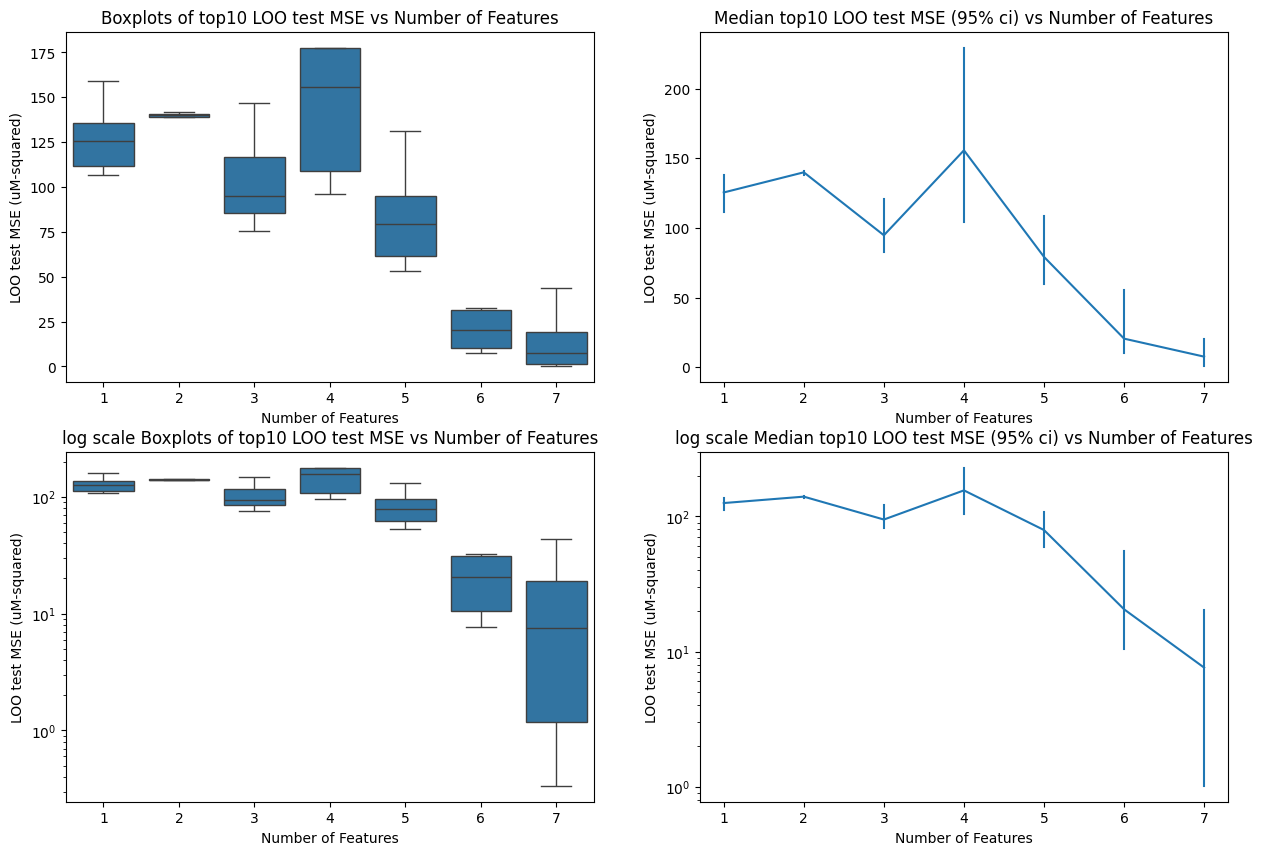

In [67]:
# # filter the data to only contain the 10 lowest MSE's for each feature number
# filtered_data = all_dfs_tr_mse.groupby('n_feats').apply(lambda x: x.nsmallest(10, 'mse')).reset_index(drop=True)
# create 2 subplots side-by-side
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
sns.boxplot(data=filtered_loo, x='n_feats', y='test_MSE_mean', showfliers=False,ax=axs[0])
axs[0].set_title("Boxplots of top10 LOO test MSE vs Number of Features")
axs[0].set_xlabel("Number of Features")
axs[0].set_ylabel("LOO test MSE (uM-squared)")

# seaborn lineplot with mean and sem
sns.lineplot(data=filtered_loo, x='n_feats', y='test_MSE_mean', estimator='median', errorbar=("ci",95), seed=RANDOM_SEED, err_style='bars',ax=axs[1])
axs[1].set_title("Median top10 LOO test MSE (95% ci) vs Number of Features")
axs[1].set_xlabel("Number of Features")
axs[1].set_ylabel("LOO test MSE (uM-squared)")

sns.boxplot(data=filtered_loo, x='n_feats', y='test_MSE_mean', showfliers=False,ax=axs[2])
axs[2].set_title("log scale Boxplots of top10 LOO test MSE vs Number of Features")
axs[2].set_xlabel("Number of Features")
axs[2].set_ylabel("LOO test MSE (uM-squared)")
axs[2].set_yscale('log')

# seaborn lineplot with mean and sem
sns.lineplot(data=filtered_loo, x='n_feats', y='test_MSE_mean', estimator='median', errorbar=("ci",95), seed=RANDOM_SEED, err_style='bars',ax=axs[3])
axs[3].set_title("log scale Median top10 LOO test MSE (95% ci) vs Number of Features")
axs[3].set_xlabel("Number of Features")
axs[3].set_ylabel("LOO test MSE (uM-squared)")
axs[3].set_yscale('log')

# save the figure to a svg file
plt.savefig('p02_loo_mse_vs_num_feats_top10.svg')

In [57]:
tab3 = filtered_loo.groupby('n_feats').agg(
    count=('test_MSE_mean', 'size'),
    min_val=('test_MSE_mean', 'min'),
    q1=('test_MSE_mean', lambda x: x.quantile(0.25)),
    median=('test_MSE_mean', 'median'),
    q3=('test_MSE_mean', lambda x: x.quantile(0.75)),
    max_val=('test_MSE_mean', 'max')
).reset_index()

baseline = filtered_loo[filtered_loo['n_feats'] == 1]['test_MSE_mean']
# save the results to a list to convert to a dataframe later
results = []
for n_feats in range(2, 8):
    group = filtered_loo[filtered_loo['n_feats'] == n_feats]['test_MSE_mean']
    stat, p = mannwhitneyu(baseline, group, alternative='greater')
    results.append({'n_feats':n_feats, 'p-value':p})
    print(f"n_feats={n_feats}, p-value={p}")
top10_pvals_loo = pd.DataFrame(results)

# calculate the median fold reduction in MSE for each n_feats group against n_feats=1
results = []
baseline = filtered_loo[filtered_loo['n_feats'] == 1]['test_MSE_mean'].median()
for n_feats in range(2, 8):
    group = filtered_loo[filtered_loo['n_feats'] == n_feats]['test_MSE_mean'].median()
    results.append({'n_feats':n_feats, 'median_fold_reduction':baseline/group})
    print(f"n_feats={n_feats}, median fold reduction={baseline/group}")
top10_fold_red_loo = pd.DataFrame(results)

tab3.merge(top10_pvals_loo, on='n_feats', how="left").merge(top10_fold_red_loo, on='n_feats', how="left")

n_feats=2, p-value=0.9843954936141299
n_feats=3, p-value=0.01056696406458055
n_feats=4, p-value=0.8462552716906593
n_feats=5, p-value=0.0014136360455584039
n_feats=6, p-value=0.0014136360455584039
n_feats=7, p-value=9.133589555477501e-05
n_feats=2, median fold reduction=0.8965936372165897
n_feats=3, median fold reduction=1.3244211443446667
n_feats=4, median fold reduction=0.8056758681736272
n_feats=5, median fold reduction=1.5841251663647837
n_feats=6, median fold reduction=6.112879678325122
n_feats=7, median fold reduction=16.517604272636834


,n_feats,count,min_val,q1,median,q3,max_val,p-value,median_fold_reduction
0,1,10,106.829561,111.946160,125.514195,135.774932,158.825518,NaN,NaN
1,2,10,135.830122,139.087441,139.990058,140.799931,141.549801,0.984395,0.896594
2,3,10,75.334854,85.404131,94.769096,116.792639,146.963994,0.010567,1.324421
3,4,10,96.084346,108.696209,155.787457,177.249252,296.906718,0.846255,0.805676
4,5,10,52.975493,61.786613,79.232499,95.154100,131.377404,0.001414,1.584125
5,6,10,7.727889,10.476228,20.532744,31.173424,188.163553,0.001414,6.112880
6,7,10,0.336216,1.179096,7.598814,19.201838,43.604488,0.000091,16.517604


In [68]:
filtered_loo.to_csv("top10_loo_test_mse_feat_groups_results.csv", index=False)
tab3.merge(top10_pvals_loo, on='n_feats', how="left").merge(top10_fold_red_loo, on='n_feats', how="left").to_csv("top10_loo_test_mse_feat_groups_results_with_pvals.csv", index=False)

# misc